In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('excel_vcb_tach.csv')

In [5]:
data.head()

,time,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,1375,VCB,20150105,16.6729,16.7774,16.4115,16.6729,310010
1,1376,VCB,20150106,16.6729,17.7704,16.6729,17.7704,1684600
2,1377,VCB,20150107,17.7704,18.0840,17.3000,17.5614,1430340
3,1378,VCB,20150108,17.5614,18.2931,17.5614,18.0840,904240
4,1379,VCB,20150109,18.0840,19.3384,18.2408,19.2862,2286680


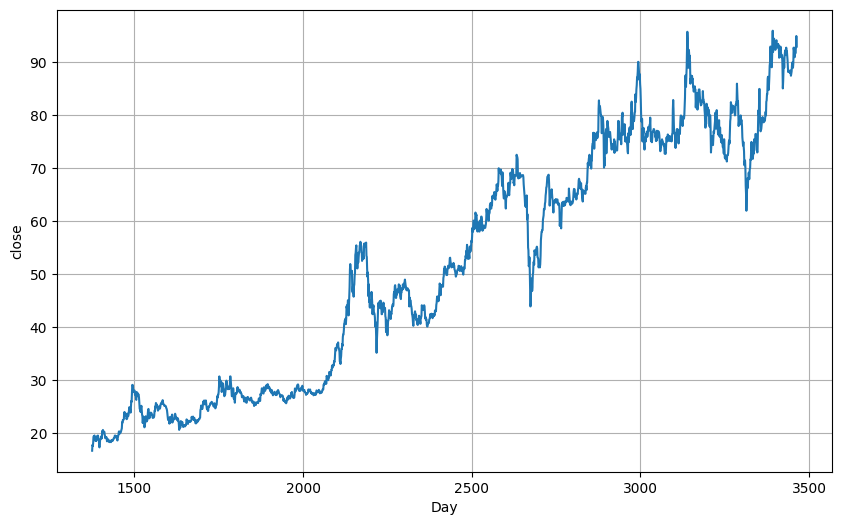

In [7]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb_tach.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='close')

In [8]:
# Define the split time
split_time = 2000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [19]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [20]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 1s 7ms/step - loss: 53.0817 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 52.7691 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 52.4279 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 52.0698 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 51.7056 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 51.3433 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 50.9888 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 50.6350 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 50.2740 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 49.8992 - lr: 2.8184e-08
Epoch 11/100
62/62 

(1e-08, 0.001, 0.0, 100.0)

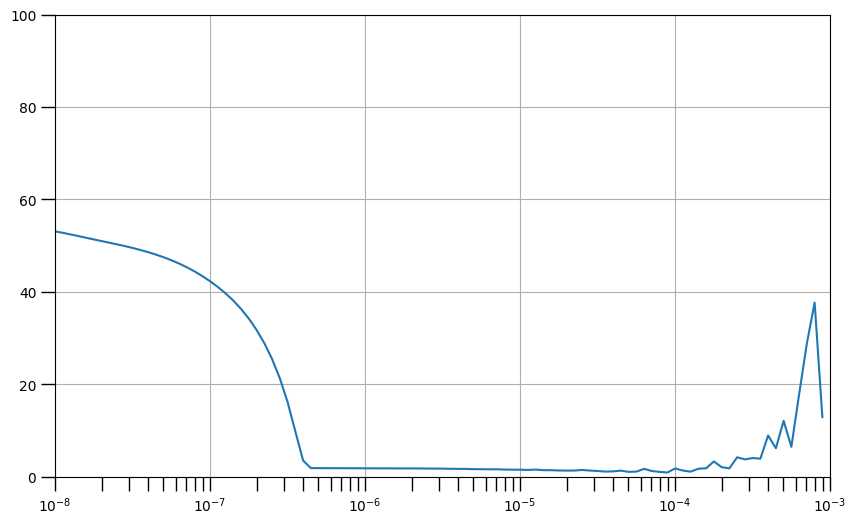

In [22]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


In [23]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [28]:
# Set the learning rate
learning_rate =1e-05

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
62/62 [==============================] - 2s 5ms/step - loss: 0.4489 - mse: 1.3477
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4282 - mse: 1.2793
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4336 - mse: 1.2925
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4531 - mse: 1.3464
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4308 - mse: 1.2866
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4307 - mse: 1.2816
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4322 - mse: 1.2896
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4241 - mse: 1.2619
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4285 - mse: 1.2833
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4289 - mse: 1.2811
Epoch 11/100
62/62 [==============================] - 0s 3m

In [29]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

3/3 [==============================] - 0s 7ms/step


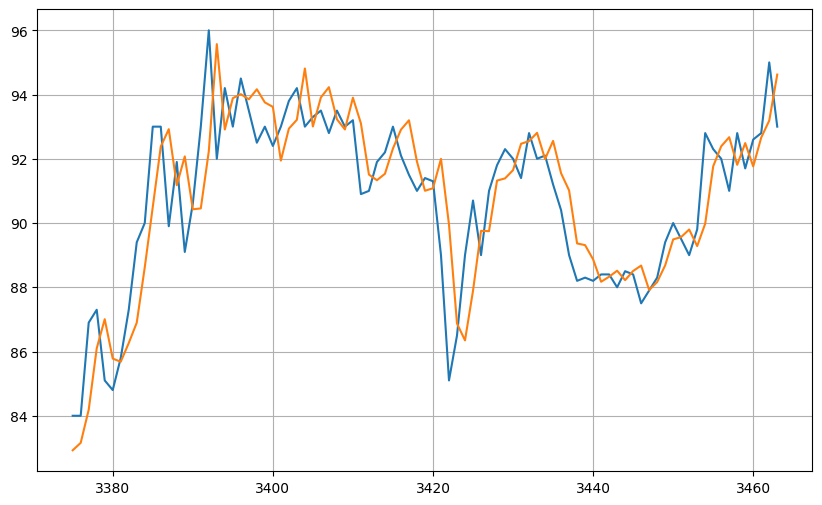

[82.92571  83.15737  84.18853  86.09792  87.00578  85.779945 85.68182
 86.26254  86.897766 88.6204   90.49655  92.38012  92.92099  91.17615
 92.07447  90.42707  90.45504  92.23495  95.56833  92.91067  93.88686
 94.0109   93.85202  94.16328  93.75469  93.61582  91.94322  92.93809
 93.2137   94.810165 93.00468  93.90954  94.22854  93.230644 92.91258
 93.89982  93.100174 91.50749  91.33269  91.533    92.319115 92.906235
 93.19808  91.911194 91.00456  91.0827   91.997375 89.95124  86.87253
 86.34689  87.890945 89.756546 89.74724  91.32115  91.389015 91.64635
 92.466644 92.55123  92.80744  91.99177  92.557076 91.54926  91.015396
 89.364365 89.31222  88.86914  88.17131  88.32834  88.51505  88.222176
 88.50745  88.67638  87.91524  88.162704 88.681694 89.48914  89.56485
 89.79769  89.282715 89.98012  91.765854 92.3884   92.671745 91.81179
 92.48722  91.7626   92.66115  93.18855  94.62156 ]


In [30]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [31]:
import numpy as np

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Tính MSE
mse = mean_squared_error(x_valid, results)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.205714884921883
